In this project, we make one-week ahead prediction for the weekly return of Amazon `AMZN` stock. We break it into four steps:

1. Retrieving training data

2. Training the model in Monument

3. Retrieving serving/testing data

4. Serving the model and computing a metric to evaluate it

In [1]:
from io import StringIO
import pandas as pd
import requests
from functools import reduce
from monument import monument

In [2]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}

apikey = "1234abcd5678efgh901112ijkl131415" # insert your own twelvedata API key here. You can apply one for free at https://twelvedata.com/register
symbol = "AMZN"
symbol0 = symbol.replace('/','') # used in file path
train_inter = "1week"
train_freq = "W-MON"
train_length = "1000"
savepath = "C:\\Users\\root\\j902-user\\projects\\twelvedata\\" # replace by your local directory

========== retreive training data ==========

We use the twelvedata Python API to retrieve financial data. It provides access to historical prices, volumes, and many useful technical indicators. Since we will make several calls, we write a function to wrap up the api calls more efficiently.

In [3]:
def paramgen(apikey, symbol, interval, outputsize):
    def urlgen(api):
        return pd.read_csv( StringIO( requests.get("https://api.twelvedata.com/" + api + "?symbol=" + symbol + "&interval=" + interval+ "&format=CSV&apikey=" + apikey + "&outputsize=" + outputsize, headers= headers).text), sep=";", parse_dates=['datetime'])
    return urlgen

In [4]:
train_raw = reduce(lambda left,right: 
    pd.merge(left,right, on='datetime'), 
    map(paramgen(apikey, symbol, train_inter, train_length),["time_series", "adx", "bbands", "beta", "ema", "macd", "rsi", "stoch"])).set_index('datetime')

# This is the range for our training
start_date = '2005-01-01'
end_date = '2020-12-31'
train = train_raw[(train_raw.index >= start_date) & (train_raw.index <= end_date)][::-1].asfreq(train_freq)

Before training, let's prepare our dataset to make sure it is useful. In time series predictions, we want our features to be stationary, which means the values are around same scales throughout the time horizon. For a period of 16 years, the stock price may have doubled, quadrupled, or even grown for more than 10x. If the price feature is used directly, our model might only learn about which time period it was, rather than one week ahead predictions.

To overcome the stationarity problem, the common solution is to transform price into growth rate. We apply `pd.DataFrame.pct_change` on non-stationary features.

In [5]:
def dataprep(df):
    target = 'close_gro1'
    stationary_list = ['adx', 'beta', 'macd_hist', 'rsi', 'slow_k', 'slow_d']
    non_stationary_list = [col for col in list(df.columns) if col not in stationary_list]
    df_grow = df[non_stationary_list].pct_change(periods=1)*100
    df_grow.columns = [str(col) + '_gro1' for col in non_stationary_list]
    df_target = df_grow.pop(target)
    out = pd.concat([df_target, df_grow, df[stationary_list]], axis=1)
    return out.iloc[1:]

train_prep = dataprep(train)

In [6]:
# take a look at the training data
train_prep

,close_gro1,open_gro1,high_gro1,low_gro1,volume_gro1,upper_band_gro1,middle_band_gro1,lower_band_gro1,ema_gro1,macd_gro1,macd_signal_gro1,adx,beta,macd_hist,rsi,slow_k,slow_d
datetime,,,,,,,,,,,,,,,,,
2005-01-10,5.269376,-6.696329,-1.716549,-0.195599,-6.148349,1.661238,0.589944,-0.775396,1.972522,-86.718003,-19.055015,14.88751,-0.52478,0.91770,56.66247,91.08832,84.54258
2005-01-17,-7.609428,5.603243,0.761308,0.489956,-28.733496,0.319932,0.305224,0.286019,-0.092139,-37.561490,-19.270272,15.84938,-0.58128,0.75126,50.18755,64.35331,76.31440
2005-01-24,2.575316,-6.434861,-4.444444,-1.852755,7.027891,0.569690,0.458958,0.314318,0.439408,-286.212718,-21.682766,16.38991,-0.57504,0.68238,52.03329,71.56945,75.67036
2005-01-31,-15.395547,2.413127,1.255814,-14.232489,188.530993,-0.547765,-0.906212,-1.375613,-2.783034,-664.218797,-7.880558,15.64448,-0.66769,0.19424,41.80407,13.61665,49.84647
2005-02-07,0.167973,-15.598492,-15.480018,1.361135,-65.471083,-0.122080,-0.651770,-1.351244,-2.260386,89.812533,4.973222,14.95229,-0.39915,-0.11289,41.91757,11.21076,32.13229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-30,-0.996767,2.944782,1.018597,1.960231,19.369495,-0.254090,0.319368,0.985553,-0.002887,-6.725126,-5.384233,39.57395,-0.39233,-43.07252,56.11277,42.93431,41.35682
2020-12-07,-1.488232,-1.620705,-1.997257,-1.687062,-11.223806,-0.179035,0.169387,0.569180,-0.299922,-9.358153,-5.998104,38.75398,-0.35262,-45.39980,54.27723,39.25051,43.26479
2020-12-14,2.716593,-0.427057,2.494926,1.730656,21.144868,0.057594,0.057248,0.056855,0.296122,-4.130533,-5.719922,38.41467,-0.53353,-40.69741,57.00110,52.79094,44.99192


In [7]:
train_prep.to_csv(savepath+'twelvedata_'+symbol0+'_train.csv', index=True)

========== train model in Monument ==========

Now we can load the training data in Monument.app to train a model. 

We select the `G-Boost` algorithm, with `lookahead = 1` and `lookback = 13`.

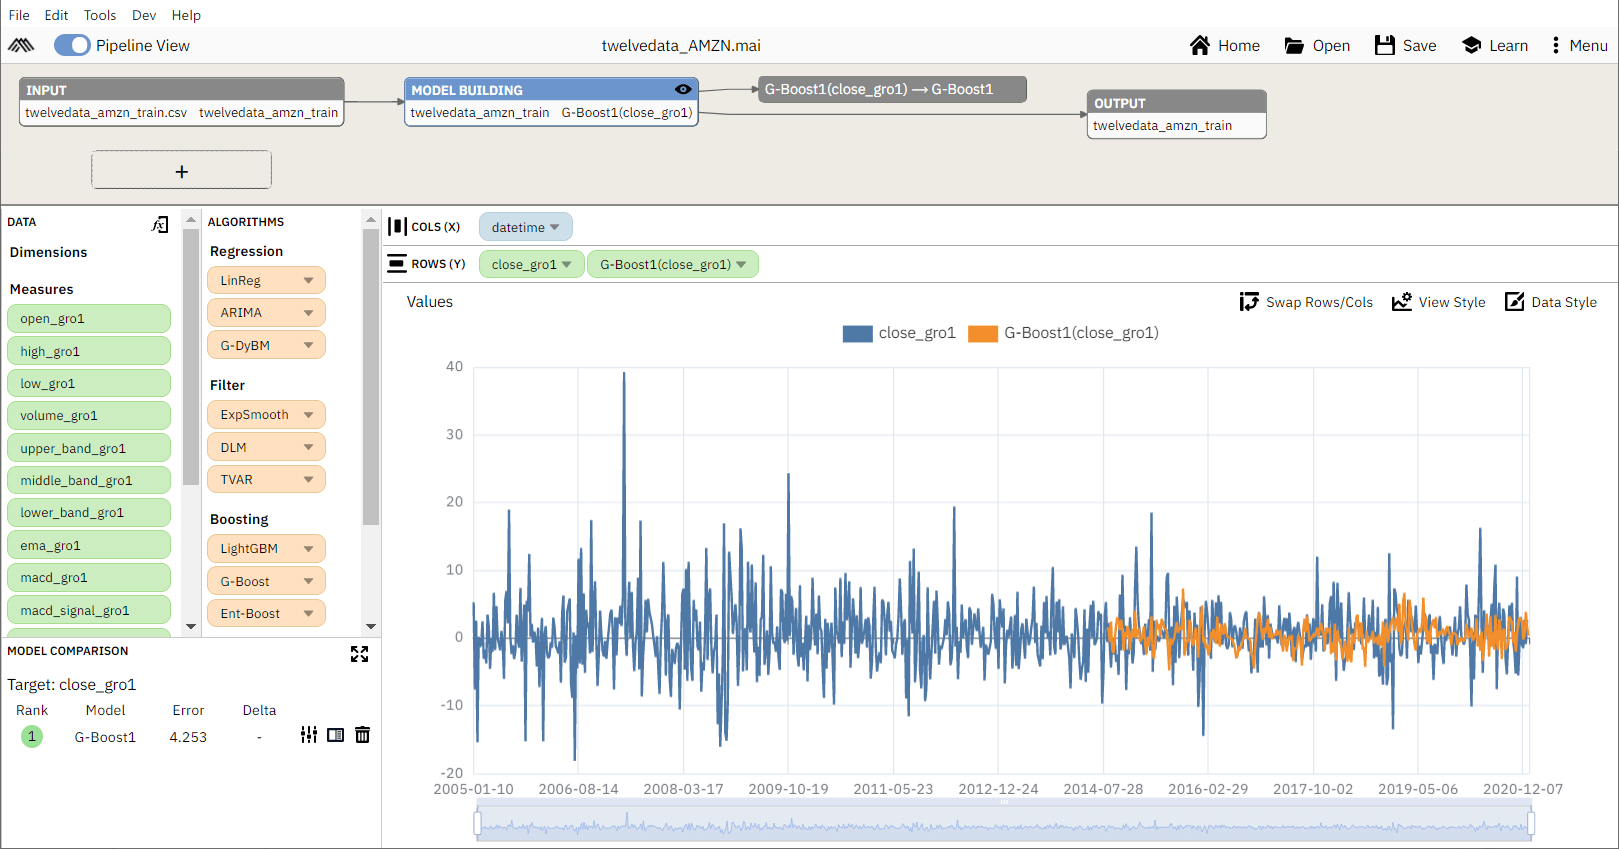

To evalute the validation result, we can create a User-Defined-Function (UDF) to compute accuracy. Accuracy should be `1` if the actual return and predicted return have same sign, and `0` if of different sign. We use the following UDF formula, and find the validation accuracy is 56%.

`Accuracy: eq(([close_gro1] > 0),([G-Boost1(close_gro1)] > 0))`

After the model is trained, click the `Save` button to save as an .mai file. Name it as `twelvedata_AMZN.mai`

========== retrieve serving data ==========

We can use the same function created above to retrieve the serving/testing data. The only difference is time range for the serving set, which should not overlap with the training set. By default twelvedata downloads data up to today (7/30/2021), so we set `serve_length = 35` to ensure serving set is isolated from the training set. You can provide the begin and end date as well.

In [8]:
serve_inter = train_inter
serve_freq = train_freq
serve_length = "35"

serve_raw = reduce(lambda left,right: 
    pd.merge(left,right, on='datetime'), 
    map(paramgen(apikey, symbol, serve_inter, serve_length),["time_series", "adx", "bbands", "beta", "ema", "macd", "rsi", "stoch"])).set_index('datetime')
serve = serve_raw[::-1].asfreq(serve_freq)
serve_prep = dataprep(serve)

In [9]:
serve_prep.to_csv(savepath+'twelvedata_'+symbol0+'_serve.csv', index=True)

========== model serving ==========

To do model serving, we will use the Monument Python package which provides a handy interface. As long as you have the `.mai` file and the serving data `.csv` file in your directory, the few lines below could do the job. Read [the package page](https://pypi.org/project/monument) for more instructions.

In [10]:
monument.init("")
maifile = savepath+'twelvedata_'+symbol0+'.mai'
csvfile = savepath+'twelvedata_'+symbol0+'_serve.csv'
algo = "G-Boost1(close_gro1)"
res = monument.serve(maifile, csvfile, algo)

The `res` is a list where the second item is a list containing our prediction results. We write a function to compute directional accuracy, similar to our UDF formula in the model training step.

In [11]:
# serve_prep = pd.read_csv(csvfile, parse_dates=['datetime']).set_index('datetime') # if not ready, read from file
def getaccu(servedata, maipred):
    # servedata is pd.DataFrame, maipred is a list
    # len(maipred) = len(servedata) + lookahead
    #     in this project, lookahead = 1
    target = 'close_gro1'
    lookahead = 1
    actual = servedata[target]
    predict = pd.Series(maipred[:-lookahead], index=actual.index)
    merged = pd.concat([actual, predict], axis=1).set_axis(['actual','predict'],axis=1).dropna()
    equal = ((merged['actual']>0) == (merged['predict']>0)) * 1
    return equal.mean()

accuracy = getaccu(serve_prep, res[1])
print("Serving accuracy is: " + str(accuracy))

Serving accuracy is: 0.5714285714285714
